In [1]:
import numpy as np
import pandas as pd
import os
from bambi import Model
import scipy as sp

import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("axes.spines", top=False, right=False)

from analysis_functions import aggregate_subject_level, sample_corr

from plotting_functions import plot_correlation, add_regression_line, cm2inch, show_img
from pymc3 import plot_posterior

In [2]:
np.random.seed(11) # from random.org

# 4. GLAM parameters predict behavior

Load data and split into even and odd trials:

In [3]:
all_data = pd.read_csv('data/data_aggregate.csv')
even = all_data[(all_data['trial'] % 2) == 0].reset_index(drop=True)
odd = all_data[(all_data['trial'] % 2) == 1].reset_index(drop=True)

Compute behavioural metric summarys for each individual, only from the odd trials:

In [4]:
odd_summary = pd.DataFrame()

for di, dataset in enumerate(odd['dataset'].unique()):
    odd_di = odd[odd['dataset'] == dataset].copy()
    n_items = odd_di['n_items'].unique()[0]
    
    odd_summary_di = aggregate_subject_level(odd_di, n_items=n_items)
    
    odd_summary = pd.concat([odd_summary, odd_summary_di])

In [5]:
odd_summary.head(20)

best_chosen           rt                                            \
               mean         mean          std     min      max          se   
subject                                                                      
0          0.822222  1704.177778   881.852300   682.0   4142.0  132.944236   
1          0.673469  1728.489796   857.141479   743.0   4602.0  123.717716   
2          0.840000  4078.660000  2623.044800   943.0  12079.0  374.720686   
3          0.704545  1893.545455   633.499496  1045.0   4742.0   96.607767   
4          0.840000  1846.640000  1093.485579   692.0   5891.0  156.212226   
5          0.800000  1217.780000   436.891258   756.0   3768.0   62.413037   
6          0.720000  3085.400000  1785.189615   986.0   8984.0  255.027088   
7          0.920000  1870.980000   582.836083  1181.0   3612.0   83.262298   
8          0.860000  1401.660000   426.574711   759.0   2818.0   60.939244   
9          0.780000  2070.280000   984.519762   653.0   4746.0  140.645680   
10         0.877551  2679.816327  2435.583789  1111.0  13278.0  351.546239   
11         0.836735  3471.816327  3341.510178   881.0  17698.0  482.305450   
12         0.805556  1717.250000   947.956028   787.0   5535.0  160.233814   
13         0.640000  3097.360000  1833.586701   873.0   7926.0  261.940957   
14         0.833333  1558.562500   525.305542   795.0   2937.0   76.623688   
15         0.880000  3908.260000  2961.066604  1226.0  17782.0  423.009515   
16         0.860000  3746.980000  1542.591761  1546.0   8326.0  220.370252   
17         0.857143  3290.408163  2937.206739   936.0  14806.0  423.949275   
18         0.897959  2455.510204  1632.151017   874.0  10804.0  235.580707   
19         0.833333  1616.250000  1195.824933   743.0   6454.0  249.346735   

                                   gaze_influence       dataset  
              q1       q3      iqr                               
subject                                                          
0        1125.00  1970.00   845.00      -0.020529  krajbich2010  
1        1166.00  1937.00   771.00       0.247233  krajbich2010  
2        2104.25  5329.00  3224.75       0.028877  krajbich2010  
3        1436.50  2175.50   739.00      -0.022031  krajbich2010  
4        1221.50  2132.50   911.00       0.103622  krajbich2010  
5         998.75  1359.25   360.50      -0.011744  krajbich2010  
6        1727.50  4017.75  2290.25       0.059901  krajbich2010  
7        1508.25  2114.75   606.50       0.290474  krajbich2010  
8        1155.25  1532.25   377.00       0.209622  krajbich2010  
9        1293.25  2498.75  1205.50       0.372487  krajbich2010  
10       1521.00  2606.00  1085.00       0.085615  krajbich2010  
11       1480.00  3354.00  1874.00       0.095918  krajbich2010  
12       1170.50  1846.00   675.50       0.150453  krajbich2010  
13       1559.75  3952.75  2393.00      -0.084967  krajbich2010  
14       1225.75  1835.25   609.50       0.156858  krajbich2010  
15       2103.00  4749.25  2646.25       0.074715  krajbich2010  
16       2534.25  4524.75  1990.50      -0.033760  krajbich2010  
17       1396.00  3700.00  2304.00       0.058923  krajbich2010  
18       1460.00  2875.00  1415.00       0.216784  krajbich2010  
19       1030.50  1595.25   564.75       0.322039  krajbich2010

Load GLAM parameter estimates, estimated from even trials only:

In [6]:
estimates = pd.DataFrame()
parameter_names = ['v', 'gamma', 's', 'tau']
for subject in odd_summary.index:
    subject_estimates_df = pd.read_csv(os.path.join('results', 'estimates', 'out_of_sample', 'multiplicative',
                                                    'estimates_{}_multiplicative_oos.csv'.format(subject)),
                                       index_col=0)
    subject_estimates_dict = {parameter: subject_estimates_df.loc[parameter + '__0_0', 'MAP']
                              for parameter in parameter_names}
    subject_estimates_dict['subject'] = subject
    estimates = pd.concat([estimates,
                           pd.DataFrame(subject_estimates_dict,
                                        index=np.ones(1)*subject)])

estimates.head()

,gamma,s,subject,tau,v
0.0,0.65,0.008368,0,0.44,0.000098
1.0,0.05,0.013663,1,0.21,0.000096
2.0,0.80,0.009960,2,1.99,0.000022
3.0,0.25,0.005090,3,0.07,0.000090
4.0,0.16,0.008927,4,0.32,0.000091


# Bayesian Mixed effects regression models

Prepare data for Bayesian Mixed Effects regression models:

In [7]:
# Format data for mixed model
df = pd.concat([estimates, odd_summary], axis=1)
df['log_rt'] = np.log(df[('rt', 'mean')])
df['log_v'] = np.log(df['v'])
df['best_chosen'] = 100 * df[('best_chosen', 'mean')]
df['gaze_influence'] = 100 * df[('gaze_influence', '')]
df['dataset'] = df[('dataset', '')]

df = df[['subject', 'dataset', 'log_rt', 'best_chosen', 'gaze_influence', 'log_v', 'gamma', 's', 'tau']].copy().reset_index(drop=True)

In [8]:
df.head()

,subject,dataset,log_rt,best_chosen,gaze_influence,log_v,gamma,s,tau
0,0,krajbich2010,7.440838,82.222222,-2.052946,-9.230543,0.65,0.008368,0.44
1,1,krajbich2010,7.455003,67.346939,24.723267,-9.251162,0.05,0.013663,0.21
2,2,krajbich2010,8.313524,84.000000,2.887728,-10.724468,0.80,0.009960,1.99
3,3,krajbich2010,7.546206,70.454545,-2.203105,-9.315701,0.25,0.005090,0.07
4,4,krajbich2010,7.521123,84.000000,10.362165,-9.304651,0.16,0.008927,0.32


In [9]:
n_samples = 20000

## Log RT ~ Log v (Figure 6a)

In [10]:
result_file = os.path.join('results', 'mixed_effects_models', '4_parameter_behavior_a_v_rt.csv')
if not os.path.isfile(result_file):
    model_a = Model(df)
    result_a = model_a.fit('log_rt ~ log_v',
                           random=['log_v|dataset'],
                           categorical=['dataset'],
                           samples=n_samples,
                           chains=2)

    summary_a = result_a.summary(ranefs=True)
    summary_a.to_csv(result_file)
else:
    print('Loading previous results from "{}"...'.format(result_file))
    summary_a = pd.read_csv(result_file, index_col=0)
summary_a

Loading previous results from "results/mixed_effects_models/4_parameter_behavior_a_v_rt.csv"...


,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin
1|dataset[folke2016],-0.036478,0.247705,-6.865614e-01,0.353188,445,1.010607
1|dataset[krajbich2010],0.091317,0.244611,-2.773712e-01,0.735978,213,1.009996
1|dataset[krajbich2011],-0.104560,0.214484,-6.437239e-01,0.237322,640,1.009184
1|dataset[tavares2017],-0.083372,0.228054,-6.615938e-01,0.297323,405,1.013754
1|dataset_sd,0.229443,0.256955,1.050007e-05,0.764077,285,1.018211
Intercept,0.021761,0.284135,-5.218034e-01,0.570559,1286,1.000392
log_rt_sd,0.112200,0.007673,9.760415e-02,0.127399,15918,1.000351
log_v,-0.788898,0.034241,-8.475716e-01,-0.709287,372,1.001845
log_v|dataset[folke2016],-0.016826,0.037698,-1.052425e-01,0.036175,125,1.014004
log_v|dataset[krajbich2010],0.005515,0.028332,-5.036431e-02,0.094310,283,1.000254


## P(choose best) ~ sigma (text only)

In [11]:
result_file = os.path.join('results', 'mixed_effects_models', '4_parameter_behavior_x_sigma_best_chosen.csv')
if not os.path.isfile(result_file):
    model_x = Model(df)
    result_x = model_x.fit('best_chosen ~ s',
                           random=['s|dataset'],
                           categorical=['dataset'],
                           samples=n_samples,
                           chains=2)
    summary_x = result_x.summary(ranefs=True)
    summary_x.to_csv(result_file)
else:
    print('Loading previous results from "{}"...'.format(result_file))
    summary_x = pd.read_csv(result_file, index_col=0)
summary_x

Loading previous results from "results/mixed_effects_models/4_parameter_behavior_x_sigma_best_chosen.csv"...


,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin
1|dataset[folke2016],-8.545108,7.331179,-23.777436,4.264606,4349,1.000180
1|dataset[krajbich2010],4.768121,6.567035,-7.625270,19.290832,6823,1.001005
1|dataset[krajbich2011],-1.870483,6.461943,-16.071978,10.901057,7152,1.000474
1|dataset[tavares2017],4.899419,7.719676,-9.732400,21.445327,4254,1.001644
1|dataset_sd,10.358782,6.109188,0.000745,21.961919,6460,1.000807
Intercept,78.450993,6.756091,65.036001,92.221394,2392,1.003105
best_chosen_sd,9.185626,0.617824,8.032478,10.445387,19230,0.999995
s,-227.307077,805.640506,-2323.485403,1253.102795,92,1.005153
s|dataset[folke2016],-436.188506,1003.744617,-2760.955012,1353.253771,247,1.000023
s|dataset[krajbich2010],-15.320234,780.518984,-1863.082392,1646.875592,103,1.002357


## Gaze_influence ~ gamma (Figure 6c)

In [12]:
result_file = os.path.join('results', 'mixed_effects_models', '4_parameter_behavior_c_gamma_gaze_influence.csv')
if not os.path.isfile(result_file):
    model_c = Model(df)
    result_c = model_c.fit('gaze_influence ~ gamma',
                           random=['gamma|dataset'],
                           categorical=['dataset'],
                           samples=n_samples,
                           chains=2)
    summary_c = result_c.summary(ranefs=True)
    summary_c.to_csv(result_file)
else:
    print('Loading previous results from "{}"...'.format(result_file))
    summary_c = pd.read_csv(result_file, index_col=0)
summary_c

Loading previous results from "results/mixed_effects_models/4_parameter_behavior_c_gamma_gaze_influence.csv"...


,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin
1|dataset[folke2016],3.102115,3.426230,-3.163433,10.392981,2492,1.000072
1|dataset[krajbich2010],0.340725,3.175260,-6.407941,6.927720,2340,1.000118
1|dataset[krajbich2011],0.660119,3.217392,-6.010809,7.287773,2222,1.000127
1|dataset[tavares2017],-3.738438,3.450434,-11.546460,2.048900,2690,1.000218
1|dataset_sd,4.780091,3.091689,0.000086,10.908243,2866,0.999975
Intercept,26.682299,3.008994,20.329528,32.773307,1929,1.000166
gamma,-26.594773,4.900976,-37.102983,-17.239387,6578,1.000328
gamma|dataset[folke2016],-1.708566,5.791617,-14.877712,9.304559,12020,1.000090
gamma|dataset[krajbich2010],1.946703,4.961793,-7.387357,13.230886,7260,1.000294
gamma|dataset[krajbich2011],-1.866250,5.242162,-13.392973,8.164298,7607,1.000292


## P(choose best) ~ gamma (Figure 6b)

In [13]:
result_file = os.path.join('results', 'mixed_effects_models', '4_parameter_behavior_b_gamma_best_chosen.csv')
if not os.path.isfile(result_file):
    model_b = Model(df)
    result_b = model_b.fit('best_chosen ~ gamma',
                           random=['gamma|dataset'],
                           categorical=['dataset'],
                           samples=n_samples,
                           chains=2)
    summary_b = result_b.summary(ranefs=True)
    summary_b.loc['gamma', 'P(>0)'] = np.mean(model_b.backend.trace.get_values('gamma') > 0)
    summary_b.to_csv(result_file)
else:
    print('Loading previous results from "{}"...'.format(result_file))
    summary_b = pd.read_csv(result_file, index_col=0)
summary_b

Loading previous results from "results/mixed_effects_models/4_parameter_behavior_b_gamma_best_chosen.csv"...


,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin,P(>0)
1|dataset[folke2016],-8.338383,4.161054,-17.111028,-0.422510,9964,1.000172,NaN
1|dataset[krajbich2010],3.599083,4.118807,-4.474070,12.083067,9659,1.000095,NaN
1|dataset[krajbich2011],-4.227917,4.131861,-12.610917,4.009374,9749,1.000184,NaN
1|dataset[tavares2017],8.701591,4.147166,0.591699,17.194108,10088,1.000332,NaN
1|dataset_sd,8.059083,2.656935,3.696207,13.416032,18394,1.000094,NaN
Intercept,76.683290,3.992970,68.773546,84.916721,9056,1.000262,NaN
best_chosen_sd,7.549834,0.514356,6.564367,8.565155,34180,0.999994,NaN
gamma,12.651590,7.757765,-3.192698,28.841020,7307,0.999980,0.94485
gamma|dataset[folke2016],17.173733,9.188220,0.121935,36.408555,9959,0.999979,NaN
gamma|dataset[krajbich2010],-9.339527,7.915352,-25.709131,7.006315,7633,0.999991,NaN


Results loaded from: results/mixed_effects_models/4_parameter_behavior_b_gamma_best_chosen_posteriorplot.png


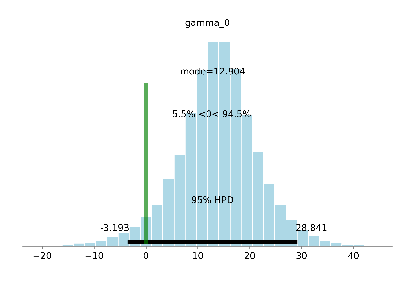

In [14]:
plot_path = os.path.join('results', 'mixed_effects_models', '4_parameter_behavior_b_gamma_best_chosen_posteriorplot.png')
if not os.path.isfile(plot_path):
    plot_posterior(model_b.backend.trace, varnames=['gamma'], ref_val=0, color='lightblue', point_estimate='mode');
    plt.savefig(plot_path, dpi=330)
else:
    print('Results loaded from: {}'.format(plot_path))
    show_img(plot_path)

# Figure 6

In [15]:
import matplotlib.patches as mpatches

def figure_6(estimates, summary, figsize=cm2inch(18., 6), alpha=0.5, fontsize=7):
    
    fig, axs = plt.subplots(1, 3, figsize=figsize)
    
    colors = np.array(['C{}'.format(i)
                       for i in range(summary['dataset'].unique().size)])
    color_idx = pd.Categorical(summary['dataset'],
                               categories=['krajbich2010', 'krajbich2011', 'folke2016', 'tavares2017'],
                               ordered=True).codes.astype(int)
    
    plot_correlation(np.log(estimates['v']),
                     np.log(summary['rt']['mean']),
                     marker='+',
                     alpha=alpha,
                     markercolor=colors[color_idx],
                     regression=False,
                     color='gray',
                     xlabel=r'Log $\hat{v}$',
                     ylabel='Log mean RT (ms)',
                     xticks=[-11, -10, -9],
                     yticks=np.arange(6, 9.5, 0.5),
                     ylim=(6, 9.125),
                     ax=axs[0])
    

    plot_correlation(estimates['gamma'],
                     summary['gaze_influence'],
                     marker='+',
                     alpha=alpha,
                     markercolor=colors[color_idx],
                     regression=False,
                     xlabel=r'$\hat{\gamma}$',
                     ylabel='Gaze influence on\nP(choice | value)',
                     xticks=[-1, 0, 1],
                     ax=axs[1],
                     annotation_pos=(0.1, 0.9),
                     color='gray')
    
    
    plot_correlation(estimates['gamma'],
                     summary['best_chosen']['mean'],
                     marker='+',
                     alpha=alpha,
                     markercolor=colors[color_idx],
                     regression=False,
                     color='gray',
                     xlabel=r'$\hat{\gamma}$',
                     ylabel='P(choose best)',
                     xticks=[-1, 0, 1],
                     ylim=(0.3, 1.0),
                     yticks=(np.arange(0.3, 1.1, 0.1)),
                     ax=axs[2])
    
    patches = [mpatches.Patch(color=color, label=label)
               for color, label in zip(colors, ['Krajbich 2010', 'Krajbich 2011', 'Folke 2016', 'Tavares 2017'])]
    axs[0].legend(patches,
                  ['Krajbich 2010', 'Krajbich 2011', 'Folke 2016', 'Tavares 2017'],
                  loc='lower left',
                  handlelength=1, handleheight=1,
                  fontsize=6, 
                  frameon=False)

    # Labels
    for label, ax in zip(list('abc'), axs.ravel()):
        ax.text(-0.25, 1.1, label, transform=ax.transAxes,
                fontsize=fontsize, fontweight='bold', va='top')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Font sizes
        ax.tick_params(axis='both', labelsize=fontsize)
        
    fig.tight_layout(pad=1)
    
    return fig, axs

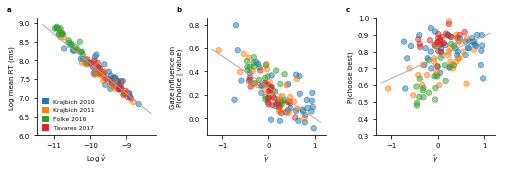

In [16]:
fig, axs = figure_6(estimates, odd_summary)

add_regression_line(axs[0], summary_a.loc['Intercept', 'mean'], summary_a.loc['log_v', 'mean'], linewidth=1)
add_regression_line(axs[1], summary_c.loc['Intercept', 'mean'] / 100, summary_c.loc['gamma', 'mean'] / 100, linewidth=1)
add_regression_line(axs[2], summary_b.loc['Intercept', 'mean'] / 100, summary_b.loc['gamma', 'mean'] / 100, linewidth=1)

plt.savefig('results/figures/figure_6_glam_parameters_predict_behavior.png', dpi=330, bbox_inches='tight')
plt.savefig('results/figures/figure_6_glam_parameters_predict_behavior.pdf', dpi=330, bbox_inches='tight')
plt.show()


# Robustness checks

## Correlation of $\gamma$ and P(choose best) within each dataset (post-hoc)

In [17]:
alpha = 0.05

for dataset in df['dataset'].unique():
    df_i = df.loc[df['dataset'] == dataset].copy()
    
    print('\n'+dataset)
    sample_corr(df_i['best_chosen'], df_i['gamma'])


krajbich2010
Normality assumption violated: True
spearman r = 0.15149076923716442, p = 0.35725530056987154

krajbich2011
pearson r = 0.619938901335866, p = 0.00025836360658335663

folke2016
pearson r = 0.7492087972674608, p = 2.5215551320240124e-05

tavares2017
pearson r = 0.4124097728541537, p = 0.040492836788055056


## Relationship between $\gamma$ and P(choose best) without first fixations

Load data without first fixations:

In [18]:
all_data_nofirst = pd.read_csv('data/data_nofirst.csv')
even_nofirst = all_data_nofirst[(all_data_nofirst['trial'] % 2) == 0].reset_index(drop=True)
odd_nofirst = all_data_nofirst[(all_data_nofirst['trial'] % 2) == 1].reset_index(drop=True)

Compute behavioural summaries for each individual, from odd trials without first fixations only:

In [19]:
odd_nofirst_summary = pd.DataFrame()

for di, dataset in enumerate(odd_nofirst['dataset'].unique()):
    odd_nofirst_di = odd_nofirst[odd_nofirst['dataset'] == dataset].copy()
    n_items = odd_nofirst_di['n_items'].unique()[0]
    
    odd_nofirst_summary_di = aggregate_subject_level(odd_nofirst_di, n_items=n_items)
    
    odd_nofirst_summary = pd.concat([odd_nofirst_summary, odd_nofirst_summary_di])

In [20]:
odd_nofirst_summary.head()

best_chosen           rt                                            \
               mean         mean          std     min      max          se   
subject                                                                      
0          0.818182  1710.500000   890.808047   682.0   4142.0  135.846954   
1          0.673469  1728.489796   857.141479   743.0   4602.0  123.717716   
2          0.840000  4078.660000  2623.044800   943.0  12079.0  374.720686   
3          0.789474  2076.368421   746.767012  1340.0   4742.0  176.014673   
4          0.836735  1867.693878  1094.508877   692.0   5891.0  157.978749   

                                   gaze_influence       dataset  
              q1       q3      iqr                               
subject                                                          
0        1121.75  1990.25   868.50       0.021164  krajbich2010  
1        1166.00  1937.00   771.00      -0.123755  krajbich2010  
2        2104.25  5329.00  3224.75       0.165827  krajbich2010  
3        1535.50  2299.00   763.50      -0.218261  krajbich2010  
4        1247.00  2134.00   887.00      -0.113096  krajbich2010

Load GLAM parameter estimates, estimated from even trials that had the first fixation removed from the data:

In [21]:
estimates_nofirst = pd.DataFrame()
parameter_names = ['v', 'gamma', 's', 'tau']
for subject in odd_nofirst_summary.index:
    subject_estimates_nofirst_df = pd.read_csv(os.path.join('results', 'estimates', 'out_of_sample', 'GLAM_nofirst',
                                                    'estimates_{}_GLAM_nofirst_oos.csv'.format(subject)),
                                       index_col=0)
    subject_estimates_nofirst_dict = {parameter: subject_estimates_nofirst_df.loc[parameter + '__0_0', 'MAP']
                              for parameter in parameter_names}
    subject_estimates_nofirst_dict['subject'] = subject
    estimates_nofirst = pd.concat([estimates_nofirst,
                           pd.DataFrame(subject_estimates_nofirst_dict,
                                        index=np.ones(1)*subject)])

estimates_nofirst.head()

,gamma,s,subject,tau,v
0.0,0.82,0.009022,0,0.40,0.000094
1.0,0.95,0.009931,1,0.13,0.000101
2.0,0.81,0.009600,2,1.79,0.000022
3.0,0.70,0.004988,3,0.01,0.000083
4.0,0.72,0.010225,4,0.29,0.000087


### Bayesian Mixed effects regressions with random slope and intercept for data sets

Prepare data for Bayesian mixed effects modeling:

In [22]:
# Format data for mixed model
df = pd.concat([estimates_nofirst, odd_nofirst_summary], axis=1)
df['log_rt'] = np.log(df[('rt', 'mean')])
df['log_v'] = np.log(df['v'])
df['best_chosen'] = 100 * df[('best_chosen', 'mean')]
df['gaze_influence'] = 100 * df[('gaze_influence', '')]
df['dataset'] = df[('dataset', '')]

df = df[['subject', 'dataset', 'log_rt', 'best_chosen', 'gaze_influence', 'log_v', 'gamma', 's', 'tau']].copy().reset_index(drop=True)

In [23]:
df.head()

,subject,dataset,log_rt,best_chosen,gaze_influence,log_v,gamma,s,tau
0,0,krajbich2010,7.444541,81.818182,2.116404,-9.272216,0.82,0.009022,0.40
1,1,krajbich2010,7.455003,67.346939,-12.375518,-9.200390,0.95,0.009931,0.13
2,2,krajbich2010,8.313524,84.000000,16.582693,-10.724468,0.81,0.009600,1.79
3,3,krajbich2010,7.638376,78.947368,-21.826137,-9.396670,0.70,0.004988,0.01
4,4,krajbich2010,7.532460,83.673469,-11.309615,-9.349602,0.72,0.010225,0.29


In [24]:
n_samples = 20000

In [25]:
from pymc3 import plot_posterior

result_file = os.path.join('results', 'mixed_effects_models', '4_robustness-check_gamma_pchoosebest_nofirst.csv')

if not os.path.isfile(result_file):
    model = Model(df)
    result = model.fit('best_chosen ~ gamma',
                       random=['gamma|dataset'],
                       categorical=['dataset'],
                       samples=n_samples,
                       chains=2)
    summary = result.summary(ranefs=True)
    summary.loc['gamma', 'P(>0)'] = np.mean(model.backend.trace.get_values('gamma') > 0)
    summary.to_csv(result_file)
else:
    print('Loading previous results from "{}"...'.format(result_file))
    summary = pd.read_csv(result_file, index_col=0)
summary

Loading previous results from "results/mixed_effects_models/4_robustness-check_gamma_pchoosebest_nofirst.csv"...


,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin,P(>0)
1|dataset[krajbich2010],0.165662,4.048481,-9.166179,7.768126,3792,1.000011,NaN
1|dataset[krajbich2011],-4.860355,4.247710,-14.291647,2.983733,3393,0.999986,NaN
1|dataset[tavares2017],3.471447,4.371224,-4.975883,13.007316,5602,1.000035,NaN
1|dataset_sd,6.293406,3.616410,0.508740,13.522915,5273,0.999975,NaN
Intercept,74.869793,4.129430,66.912973,83.665470,3204,0.999994,NaN
best_chosen_sd,7.767048,0.572194,6.704250,8.931710,20074,0.999982,NaN
gamma,8.780299,4.085390,0.141217,17.084060,2447,0.999997,0.972725
gamma|dataset[krajbich2010],-0.389844,3.855768,-9.237151,7.973158,2743,0.999984,NaN
gamma|dataset[krajbich2011],0.651618,4.117170,-7.516587,10.327755,2315,0.999996,NaN
gamma|dataset[tavares2017],1.075043,4.578789,-7.897731,12.063872,3804,0.999980,NaN


Results loaded from: results/mixed_effects_models/4_robustness-check_gamma_pchoosebest_nofirst_posteriorplot.png


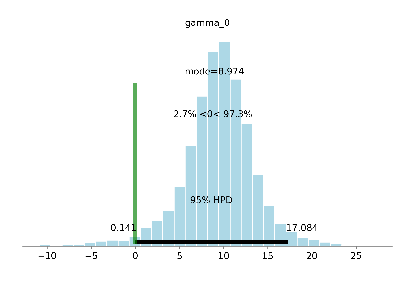

In [26]:
plot_path = os.path.join('results', 'mixed_effects_models', '4_robustness-check_gamma_pchoosebest_nofirst_posteriorplot.png')
if not os.path.isfile(plot_path):
    plot_posterior(model.backend.trace, varnames=['gamma'], ref_val=0, color='lightblue', point_estimate='mode');
    plt.savefig(plot_path, dpi=330)
else:
    print('Results loaded from: {}'.format(plot_path))
    show_img(plot_path)

The effect is still present, even after removing all first fixations from the data.

# The relationship with $\gamma$ estimates from additive variant

In [27]:
estimates_additive = pd.DataFrame()
parameter_names = ['v', 'gamma', 's', 'tau']
for subject in odd_summary.index:
    subject_estimates_additive_df = pd.read_csv(os.path.join('results', 'estimates', 'out_of_sample', 'additive',
                                                    'estimates_{}_additive_oos.csv'.format(subject)),
                                       index_col=0)
    subject_estimates_additive_dict = {parameter: subject_estimates_additive_df.loc[parameter + '__0_0', 'MAP']
                                       for parameter in parameter_names}
    subject_estimates_additive_dict['subject'] = subject
    estimates_additive = pd.concat([estimates_additive,
                                    pd.DataFrame(subject_estimates_additive_dict,
                                                 index=np.ones(1)* subject)])

estimates_additive.head()

,gamma,s,subject,tau,v
0.0,1.78,0.008020,0,0.36,0.000096
1.0,7.87,0.010117,1,0.10,0.000100
2.0,0.49,0.008944,2,1.00,0.000023
3.0,1.11,0.004812,3,0.01,0.000089
4.0,6.00,0.009909,4,0.20,0.000092


In [28]:
# Format data for mixed model
df = pd.concat([estimates_additive, odd_summary], axis=1)
df['log_rt'] = np.log(df[('rt', 'mean')])
df['log_v'] = np.log(df['v'])
df['best_chosen'] = 100 * df[('best_chosen', 'mean')]
df['gaze_influence'] = 100 * df[('gaze_influence', '')]
df['dataset'] = df[('dataset', '')]

df = df[['subject', 'dataset', 'log_rt', 'best_chosen', 'gaze_influence', 'log_v', 'gamma', 's', 'tau']].copy().reset_index(drop=True)

In [29]:
from pymc3 import plot_posterior

result_file = os.path.join('results', 'mixed_effects_models', '4_robustness-check_gamma-additive_pchoosebest.csv')

if not os.path.isfile(result_file):
    model = Model(df)
    result = model.fit('best_chosen ~ gamma',
                       random=['gamma|dataset'],
                       categorical=['dataset'],
                       samples=n_samples,
                       chains=2)
    summary = result.summary(ranefs=True)
    summary.loc['gamma', 'P(>0)'] = np.mean(model.backend.trace.get_values('gamma') > 0)
    summary.to_csv(result_file)
else:
    print('Loading previous results from "{}"...'.format(result_file))
    summary = pd.read_csv(result_file, index_col=0)
summary

Loading previous results from "results/mixed_effects_models/4_robustness-check_gamma-additive_pchoosebest.csv"...


,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin,P(>0)
1|dataset[folke2016],-6.124273,4.229299,-14.692578,1.952894,7707,1.000071,NaN
1|dataset[krajbich2010],1.207260,3.924695,-6.717945,9.284345,6826,1.000188,NaN
1|dataset[krajbich2011],-1.733099,4.074861,-10.179785,6.365572,7552,1.000005,NaN
1|dataset[tavares2017],7.609854,4.434981,-0.734537,16.626238,8804,1.000221,NaN
1|dataset_sd,7.204440,3.203371,1.954305,14.144801,12574,1.000011,NaN
Intercept,81.956893,3.809756,74.028124,89.702657,6263,1.000199,NaN
best_chosen_sd,8.067291,0.546230,7.017159,9.149817,33114,0.999975,NaN
gamma,-0.536286,0.222777,-0.978055,-0.056238,8212,1.000015,0.02175
gamma|dataset[folke2016],-0.142734,0.245243,-0.699783,0.292865,7849,1.000053,NaN
gamma|dataset[krajbich2010],0.087989,0.235987,-0.354013,0.645164,10709,1.000002,NaN


Results loaded from: results/mixed_effects_models/4_robustness-check_gamma-additive_pchoosebest_posteriorplot.png


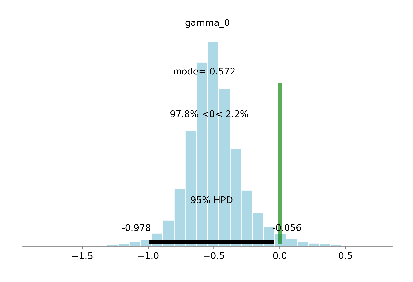

In [30]:
plot_path = os.path.join('results', 'mixed_effects_models', '4_robustness-check_gamma-additive_pchoosebest_posteriorplot.png')
if not os.path.isfile(plot_path):
    plot_posterior(model.backend.trace, varnames=['gamma'], ref_val=0, color='lightblue', point_estimate='mode');
    plt.savefig(plot_path, dpi=330)
else:
    print('Results loaded from: {}'.format(plot_path))
    show_img(plot_path)

# $\gamma$ estimates for multiplicative and additive variant

In [31]:
estimates_multiplicative = pd.DataFrame()
parameter_names = ['v', 'gamma', 's', 'tau']
for subject in odd_summary.index:
    subject_estimates_multiplicative_df = pd.read_csv(os.path.join('results', 'estimates', 'in_sample', 'GLAM',
                                                    'estimates_{}_GLAM_ins.csv'.format(subject)),
                                       index_col=0)
    subject_estimates_multiplicative_dict = {parameter: subject_estimates_multiplicative_df.loc[parameter + '__0_0', 'MAP']
                              for parameter in parameter_names}
    subject_estimates_multiplicative_dict['subject'] = subject
    estimates_multiplicative = pd.concat([estimates_multiplicative,
                           pd.DataFrame(subject_estimates_multiplicative_dict,
                                        index=np.ones(1)*subject)])

estimates_multiplicative.head()

,gamma,s,subject,tau,v
0.0,0.79,0.010750,0,0.49,0.000084
1.0,-0.13,0.009213,1,0.22,0.000095
2.0,0.82,0.009846,2,1.17,0.000024
3.0,0.58,0.006562,3,0.09,0.000089
4.0,0.51,0.009910,4,0.30,0.000090


In [32]:
estimates_multiplicative = pd.DataFrame()
parameter_names = ['v', 'gamma', 's', 'tau']
for subject in odd_summary.index:
    subject_estimates_multiplicative_df = pd.read_csv(os.path.join('results', 'estimates', 'in_sample', 'GLAM',
                                                    'estimates_{}_GLAM_ins.csv'.format(subject)),
                                       index_col=0)
    subject_estimates_multiplicative_dict = {parameter: subject_estimates_multiplicative_df.loc[parameter + '__0_0', 'MAP']
                              for parameter in parameter_names}
    subject_estimates_multiplicative_dict['subject'] = subject
    estimates_multiplicative = pd.concat([estimates_multiplicative,
                           pd.DataFrame(subject_estimates_multiplicative_dict,
                                        index=np.ones(1)*subject)])

estimates_multiplicative.head()

,gamma,s,subject,tau,v
0.0,0.79,0.010750,0,0.49,0.000084
1.0,-0.13,0.009213,1,0.22,0.000095
2.0,0.82,0.009846,2,1.17,0.000024
3.0,0.58,0.006562,3,0.09,0.000089
4.0,0.51,0.009910,4,0.30,0.000090


In [33]:
estimates_additive = pd.DataFrame()
parameter_names = ['v', 'gamma', 's', 'tau']
for subject in odd_summary.index:
    subject_estimates_additive_df = pd.read_csv(os.path.join('results', 'estimates', 'in_sample', 'additive',
                                                    'estimates_{}_additive_ins.csv'.format(subject)),
                                       index_col=0)
    subject_estimates_additive_dict = {parameter: subject_estimates_additive_df.loc[parameter + '__0_0', 'MAP']
                              for parameter in parameter_names}
    subject_estimates_additive_dict['subject'] = subject
    estimates_additive = pd.concat([estimates_additive,
                           pd.DataFrame(subject_estimates_additive_dict,
                                        index=np.ones(1)*subject)])

estimates_additive.head()

,gamma,s,subject,tau,v
0.0,1.21,0.010469,0,0.40,0.000085
1.0,8.71,0.009414,1,0.11,0.000094
2.0,0.91,0.010088,2,1.70,0.000024
3.0,1.38,0.006449,3,0.08,0.000090
4.0,3.66,0.009996,4,0.24,0.000089


Normality assumption violated: True
spearman r = -0.8581596122523555, p = 2.2136512452440841e-35


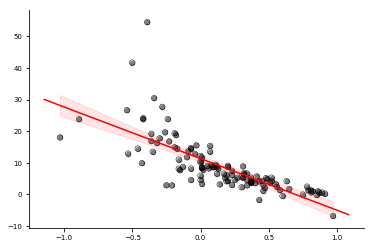

In [34]:
plot_correlation(estimates_multiplicative['gamma'],
                 estimates_additive['gamma'], annotate=False)
sample_corr(estimates_multiplicative['gamma'], estimates_additive['gamma'])